In [1]:
import pandas as pd

Get data per node (the increase from start to end).

In [2]:
def get_total_per_node(df: pd.DataFrame):
    maxval = df.groupby(['node_name'])['value'].max()
    maxval.name = 'maxval'
    minval = df.groupby(['node_name'])['value'].min()
    minval.name = 'minval'

    values = pd.concat([maxval, minval], axis=1)
    values['node_name'] = values.index
    values.index = values.index.rename('idx')
    values['delta'] = values['maxval'] - values['minval']
    return values

Calculate the average increase per round per metric.

In [3]:
def get_average(df: pd.DataFrame):
    values = get_total_per_node(df)
    values = values[values['node_name'].str.contains('client')==False]
    avg = values.delta.mean()
    return avg

Calculate the average from all rounds (all Excel sheets).

In [4]:
def get_all_rounds(filename: str):
    xls = pd.ExcelFile(filename)
    data = []
    
    for sheet in xls.sheet_names:
        df = pd.read_excel(filename, sheet)
        avg = get_average(df)
        data.append([sheet, avg])
    
    all_rounds = pd.DataFrame(data, columns=['sheet', 'value'])
    return all_rounds

Parse all statistics

In [5]:
files = {
    'pbft': {
        'cpu': 'pbft_cpu_time.xlsx',
        'memory': 'pbft_memory.xlsx',
        'rcv': 'pbft_network_rcv.xlsx',
        'tx': 'pbft_network_tx.xlsx',
    },
    'pow': {
        'cpu': 'pow_cpu_time.xlsx',
        'memory': 'pow_memory.xlsx',
        'rcv': 'pow_network_rcv.xlsx',
        'tx': 'pow_network_tx.xlsx',
    }
}

titles = {
    'cpu': 'Cumulative CPU time consumed in seconds',
    'memory': 'Memory usage in bytes',
    'rcv': 'Bytes received over the network',
    'tx': 'Bytes transmitted over the network',
}

yaxis_titles = {
    'cpu': 'CPU time consumed (s)',
    'memory': 'Memory usage (bytes)',
    'rcv': 'Bytes received',
    'tx': 'Bytes transmitted',
}

stats = list(files['pbft'].keys())
"""
    stat pbft pow transactions
    cpu  x    y   1000
    cpu  x    y   500
    mem  a    b   1000
    mem  a    b   500
    ...
""" 
avg_data = []

transactions = [200, 500, 1000]
consensus = ['pow', 'pbft']
# mechanisms = [f'{cons} {t}' for t in transactions for cons in consensus]

for t in transactions:
    for stat in stats:
        data_row = [stat, t]
        pbft = get_all_rounds(f"data/{t}/{files['pbft'][stat]}")
        pow = get_all_rounds(f"data/{t}/{files['pow'][stat]}")
        data_row.append(pbft.value.mean())
        data_row.append(pow.value.mean())
        avg_data.append(data_row)

avg_df = pd.DataFrame(avg_data, columns=['stat', 'transactions'] + consensus)

avg_df


,stat,transactions,pow,pbft
0,cpu,200,5.477860e-01,3.097675e-02
1,memory,200,9.961275e+07,5.731287e+06
2,rcv,200,6.334033e+06,1.257200e+06
3,tx,200,3.733783e+06,1.303771e+06
4,cpu,500,1.502620e+00,4.050679e-01
5,memory,500,2.814029e+08,5.964702e+07
6,rcv,500,1.885518e+07,3.438144e+07
7,tx,500,1.151957e+07,3.616333e+07
8,cpu,1000,3.099367e+00,1.342399e+00
9,memory,1000,5.777999e+08,1.371597e+08


Plot data with the use of matplotlib.

In [6]:
avg_df[avg_df.stat == 'cpu']

,stat,transactions,pow,pbft
0,cpu,200,0.547786,0.030977
4,cpu,500,1.502620,0.405068
8,cpu,1000,3.099367,1.342399


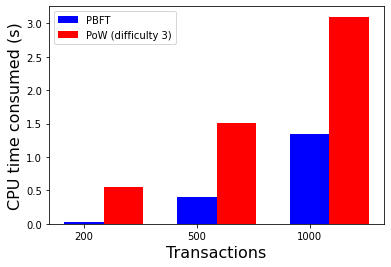

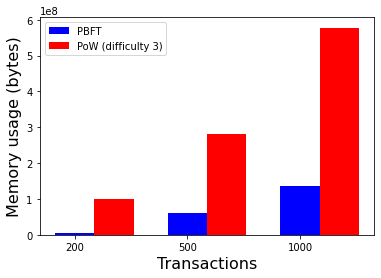

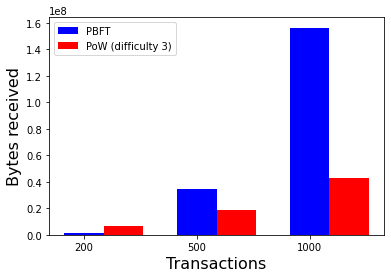

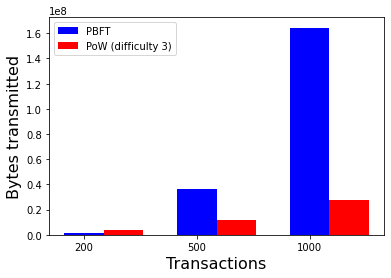

In [19]:
from matplotlib import pyplot as plt
import numpy as np

metrics = list(avg_df.stat.unique())
consensus_labels = ['PBFT', 'PoW (difficulty 3)']

for metric in metrics:
    tx = list(avg_df.transactions.unique())
    vals_pow = avg_df[avg_df.stat == metric]['pow'].tolist()
    vals_pbft = avg_df[avg_df.stat == metric]['pbft'].tolist()
    pos = np.arange(len(tx))
    bar_width = 0.35

    plt.figure()
    # plt.title(titles[metric], fontsize=16)
    plt.bar(pos, vals_pbft, bar_width, color='blue')
    plt.bar(pos+bar_width, vals_pow, bar_width, color='red')
    plt.xticks(pos, tx)
    plt.xlabel('Transactions', fontsize=16)
    plt.ylabel(yaxis_titles[metric], fontsize=16)
    plt.legend(consensus_labels, loc=2)
plt.show()

Total time taken to submit the transactions by the consensus and number of transactions.

In [8]:
transactions = [200, 500, 1000]
pbft_rounds = pd.DataFrame(columns=['round_number', 'transactions', 'total_time'])
pow_rounds = pd.DataFrame(columns=['round_number', 'transactions', 'total_time'])

for t in transactions:
    pbft_rounds = pd.concat([pbft_rounds, pd.read_excel(f"data/{t}/pbft_rounds_data.xlsx")], ignore_index=True)
    pow_rounds = pd.concat([pow_rounds, pd.read_excel(f"data/{t}/pow_rounds_data.xlsx")], ignore_index=True)


pbft_avg = []
pow_avg = []
for t in transactions:
    pbft_avg.append(pbft_rounds[pbft_rounds['transactions']==t]['total_time'].mean())
    pow_avg.append(pow_rounds[pow_rounds['transactions']==t]['total_time'].mean())


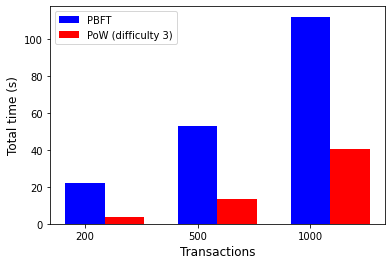

In [9]:
pos = np.arange(len(tx))
bar_width = 0.35

plt.figure()
# plt.title('Average time taken to submit the transactions', fontsize=16) # title set in the document
plt.bar(pos, pbft_avg, bar_width, color='blue')
plt.bar(pos+bar_width, pow_avg, bar_width, color='red')
plt.xticks(pos, tx)
plt.xlabel('Transactions', fontsize=12)
plt.ylabel('Total time (s)', fontsize=12)
plt.legend(consensus_labels, loc=2)
plt.show()

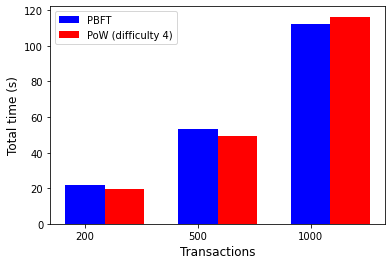

In [10]:
pow4_rounds = pd.DataFrame(columns=['round_number', 'transactions', 'total_time'])

for t in transactions:
    pow4_rounds = pd.concat([pow4_rounds, pd.read_excel(f"data/{t}/pow4_rounds_data.xlsx")], ignore_index=True)


pow4_avg = []
for t in transactions:
    pow4_avg.append(pow4_rounds[pow4_rounds['transactions']==t]['total_time'].mean())

consensus_labels = ['PBFT', 'PoW (difficulty 4)']

plt.figure()
# plt.title('Average time taken to submit the transactions', fontsize=16) # title set in the document
plt.bar(pos, pbft_avg, bar_width, color='blue')
plt.bar(pos+bar_width, pow4_avg, bar_width, color='red')
plt.xticks(pos, tx)
plt.xlabel('Transactions', fontsize=12)
plt.ylabel('Total time (s)', fontsize=12)
plt.legend(consensus_labels, loc=2)
plt.show()

Calculate the average tps (transactions per second).

In [12]:
def get_tps(transactions, time)->float:
    avgs = []
    for i, t in enumerate(transactions):
        avgs.append(t / time[i])
    return round(sum(avgs)/len(transactions), 2)

tps_pbft = get_tps(transactions, pbft_avg)
tps_pow3 = get_tps(transactions, pow_avg)
tps_pow4 = get_tps(transactions, pow4_avg)
print(tps_pbft, tps_pow3, tps_pow4)

9.13 38.06 9.71


Calculate TPS for difficulty 5 PoW.

In [13]:
pow5_rounds = pd.read_excel("data/200/pow5_rounds_data.xlsx")

pow5_avg = pow5_rounds[pow5_rounds['transactions']==200]['total_time'].mean()
tps_pow5 = get_tps([200], [pow5_avg])
print(tps_pow5)

0.77


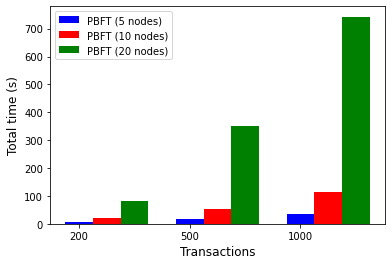

In [18]:
def get_rounds_data(consensus, transactions):
    rounds = pd.DataFrame(columns=['round_number', 'transactions', 'total_time'])

    for t in transactions:
        rounds = pd.concat([rounds, pd.read_excel(f"data/{t}/{consensus}_rounds_data.xlsx")], ignore_index=True)

    return rounds

pbft5_rounds = get_rounds_data('pbft_5_nodes', transactions)
pbft10_rounds = get_rounds_data('pbft', transactions)
pbft20_rounds = get_rounds_data('pbft_20_nodes', [200, 500])

pbft5_avg = []
pbft10_avg = []
pbft20_avg = []

for t in transactions:
    pbft5_avg.append(pbft5_rounds[pbft5_rounds['transactions']==t]['total_time'].mean())
    pbft10_avg.append(pbft10_rounds[pbft10_rounds['transactions']==t]['total_time'].mean())
    pbft20_avg.append(pbft20_rounds[pbft20_rounds['transactions']==t]['total_time'].mean())

consensus_labels = ['PBFT (5 nodes)', 'PBFT (10 nodes)', 'PBFT (20 nodes)']

bar_width = 0.25

plt.figure()
# plt.title('Average time taken to submit the transactions', fontsize=16) # title set in the document
plt.bar(pos, pbft5_avg, bar_width, color='blue')
plt.bar(pos+bar_width, pbft10_avg, bar_width, color='red')
plt.bar(pos+2*bar_width, pbft20_avg, bar_width, color='green')
plt.xticks(pos, tx)
plt.xlabel('Transactions', fontsize=12)
plt.ylabel('Total time (s)', fontsize=12)
plt.legend(consensus_labels, loc=2)
plt.show()